IMDB Sentiment Notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

dataset has 100K reviews. 25k are between positive and negative for training, another 25k for testing. remaining 50k are unlabeled.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)

In [4]:
path.ls()

[PosixPath('/floyd/home/fastai/data/imdb_sample/texts.csv'),
 PosixPath('/floyd/home/fastai/data/imdb_sample/.ipynb_checkpoints'),
 PosixPath('/floyd/home/fastai/data/imdb_sample/tmp')]

In [5]:
df = pd.read_csv(path/'texts.csv')

In [6]:
df.head(10)

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False
5,negative,"From the start, you know how this movie will e...",False
6,negative,There were a lot of truly great horror movies ...,False
7,negative,I was fortunate enough to meet George Pal (and...,False
8,negative,This film is the freshman effort of Stephanie ...,False
9,negative,Greg Davis and Bryan Daly take some crazed sta...,False


In [7]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [8]:
df['label'][1]

'positive'

In [9]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

Unlike images, which can be fed almost directly into a model because they're just a big array of pixel values that are floats between 0 and 1, text is composed of words, and we can't apply math functions to words directly. We first have to convert them to numbers. This is done in two different steps: 

1. Tokenization
2. Numericalization.

A TextDataBunch does this all behind the scenes for you.

In [10]:
data_lm.save()

In [11]:
data = TextDataBunch.load(path)

## Tokenization

The first step of processing of text we go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter

* we need to take care of punctuation
* some words are contractions of two different words, like isnt or dont
* we may need to clean some parts of our texts, if there's HTML code for example

To see what the tokenizer has done behind the scenes, let's have a look at a few texts in a batch

In [12]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might , no matter how warm and gooey raising victor vargas became i was always aware that something did n't quite feel right . victor vargas suffers from a certain xxunk on the director 's part . apparently , the director thought that the ethnic backdrop of a latino family on the",negative
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying to watch a film director change his style / subject , but soderbergh 's most recent stinker , the girlfriend xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be soderbergh 's main challenge . strange , after xxunk years",negative
"xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . with graphics that are terribly dated today , the game xxunk you into the role of xxunk even * think * i 'm going to attempt spelling his last name ! ) , an american",positive
"xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . the only problem is half of them are straight and james does n't know this . if",negative
"xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the format is the same as max xxunk ' "" la xxunk , "" based on a play by arthur xxunk , who is given an "" inspired by "" credit . it starts from one person , a prostitute , standing on a street xxunk in brooklyn . she is picked",positive
"xxfld 1 how viewers react to this new "" adaption "" of shirley jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one ... and those who have never been exposed to either , and who are big fans of hollywood 's current trend towards "" special effects "" being the first and last word",negative
"xxfld 1 to review this movie , i without any doubt would have to quote that memorable scene in tarantino 's "" pulp fiction "" ( xxunk ) when jules and vincent are talking about mia wallace and what she does for a living . jules tells vincent that the "" only thing she did worthwhile was pilot "" . vincent asks "" what the hell is a pilot ? "" and jules goes into a very well description of what a tv pilot is : "" well , the way they make shows is , they make one show",negative
"xxfld 1 \n\n i 'm sure things did n't exactly go the same way in the real life of homer hickam as they did in the film adaptation of his book , rocket boys , but the movie "" october sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read hickam 's memoirs , but i am still able to enjoy and understand their film adaptation . the film , directed by joe xxunk and written by lewis xxunk , xxunk the story of teenager homer hickam (",positive
"xxfld 1 well , what can i say . \n\n "" what the xxunk do we know "" has achieved the nearly impossibl

## Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear in the list twice with a max vocabulary size of 60k by feault and replace the ones that dont make the cut by the unknown token UNK.

The correspondence from ids tokens is stored in the vocab attribute of our datasets, in a dictionary called `itos` (for int to string)

In [13]:
data.vocab

In [14]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

In [15]:
data.train_ds[0][0][:5]

[43, 40, 34, 170, 61]

## With the data block API
We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example, the data was randomly split between train and validation sets instead of reading the third column.

With the data block API, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelent, so it will be more readable

In [16]:
data = (TextSplitData.from_csv(path, 'texts.csv', input_cols=1, label_cols=0, valid_col=2)
       .datasets(TextDataset)
       .tokenize()
       .numericalize()
       .databunch(TextDataBunch))

In [17]:
# now lets grab the full dataset for what follows
path = untar_data(URLs.IMDB)

In [18]:
path.ls()

[PosixPath('/floyd/home/fastai/data/imdb/README'),
 PosixPath('/floyd/home/fastai/data/imdb/models'),
 PosixPath('/floyd/home/fastai/data/imdb/train'),
 PosixPath('/floyd/home/fastai/data/imdb/tmp_lm'),
 PosixPath('/floyd/home/fastai/data/imdb/imdb.vocab'),
 PosixPath('/floyd/home/fastai/data/imdb/test')]

In [19]:
(path/'train').ls()

[PosixPath('/floyd/home/fastai/data/imdb/train/unsup'),
 PosixPath('/floyd/home/fastai/data/imdb/train/neg'),
 PosixPath('/floyd/home/fastai/data/imdb/train/pos'),
 PosixPath('/floyd/home/fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/floyd/home/fastai/data/imdb/train/labeledBow.feat')]

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia call wikitext-103). That model has been trained to guess what the next word is . its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new world. This hidden state thus contains information about the sentence up to that point.

We are going to use that knowledge ofthe English lanague to build our classififer, but first, like for computer vision, we need to fine tune the pretrained model to our particular dataset. Because the english of the review left by people on IMDB isnt the same as the English of wikipedia, we'll need to adjust a little bit of the parameters in our model. Plus there might be some words extremeley common in that dataset that were barely present in wikiedpia, and therefore might not be part of the vocab the model was traine don.

This is where the unlabeled data is going to be useful to use, as we can use it to fine tune our model. LEt's create our data object with the data block API

In [20]:
data_lm = (TextFileList.from_folder(path)
          # grab all the text files in path
          .label_const(0)
          # label them all with 0s (the targets arent positive vs negative here)
          .split_by_folder(valid='test')
          # split by folder between train and validation set
          .datasets()
          .tokenize()
          .numericalize()
          .databunch(TextLMDataBunch))
data_lm.save('tmp_lm')

In [21]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm')
data_lm.show_batch()

idx,text
0,"xxfld 1 it was originally called "" map of the universe "" . \n\n the book came out in 1994 . \n\n then there was the tv show : ' est ' and parts of it are in the film . \n\n "" xxup est "" is just a series of people living in the dark for a period of one month . \n\n like in the film they are all filmed with infra red cameras . \n\n they sleep , eat , shower , go to the bathroom all in the dark . \n\n"
1,"picture and you 'll want to know where the writers are taking you . the result of that is that its a series which does not let you go . on a more sceptic note , the series went under a bit in season 2 , probably due to its own success . it is well known that lost was only written for one season originally and when the overwhelming success followed , the writers were overwhelmed too . in my opinion they made the mistake to add even more mysteries and in a higher"
2,". but i think about half the running time of the film was composed of close - ups featuring her amazingly limited acting range : from nervous all the way to tremulous . after about twenty minutes , i just grew tired of looking at her . and in this film , she 's about all there is . \n\n not one moment of this whole tortured mess felt genuine . but , hey , the scenery was great . so one has to give france xxup and the second unit its props . xxfld"
3,"which seems to be the favorite catch - phrase of this movie . but with a secure job and a secure income within his grasp , josh decides for whatever stupid reason that he does n't want to do it . he hopelessly bungles several minor tasks and his laziness and lack of ambition fill me with contempt . his inability to send several "" very important "" letters within a given amount of time is supposed to be hilarious , but is merely stupid . josh meets and deceives a lawyer woman and they"
4,is full frontal of scuddamore ( surprising for any movie ) but one girl decides to take a bath alone ... xxup after they know a killer is wandering around after them ! and then there 's the couple that has to have sex . this is the type of film where the killer seems to know where everybody is going to be and can teleport himself to them . it ends with a twist which had me groaning and rolling my eyes then xxup another twist which had me wanting to throw something heavy
5,"on her own and trying to convince her aunts to let go as she left the nest . the older episodes were cute , but it was just so much better to see her as ( well not really a teenage witch anymore ) but an adult witch . i loved roxy and xxunk ; they were so talented ! in the earlier episodes the aunts were great actresses , but they were so strict , kind and loving , but they treated her like a young child in some ways , but not in"
6,"xxunk xxfld 1 bordello of blood is a somewhat disappointing follow up to the previous ( and far superior ) tales from the crypt feature "" demon knight "" . while it retains the possibly even more stupid and irritating this time around cryptkeeper mini sections at the beginning and end of the story it lacks demon knight 's best attribute , a sharp , quality script , and a fun thrilling main story , which more than made up for having to endure the noxious cryptkeeper last time out . that s not to"
7,". \n\n it 's a classic / simple story of a couple who have lost the spice in their relationship , who break up , seek other people and then discover that , perhaps , what they had was better after all . \n\n frederic forrest and teri garr give excellent performances as the bored couple . frederic forrest in particular does a great job giving the audience the sense of a regular guy who thinks that something exotic is what he really needs . he 's also gives a great emotional baring when he"
8,"movie that has ron xxunk from welcome back kotter as the male lead sex symbol . not much , i guess and that 's exactly what i got ! not much ! when i popped the xxup dvd of hellgate on i realized less than five minutes into it that i had seen

In [22]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

In [23]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


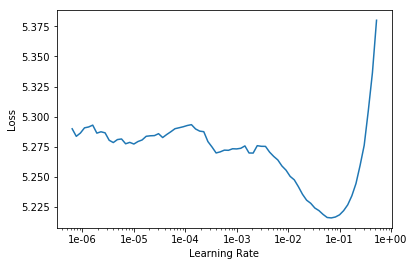

In [24]:
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

Total time: 1:05:33
epoch  train_loss  valid_loss  accuracy
1      4.603358    4.442695    0.250414  (1:05:33)



In [26]:
learn.save('fit_head')

In [27]:
learn.load('fit_head')

LanguageLearner(data=<fastai.text.data.TextLMDataBunch object at 0x7fe2ac882400>, model=SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=True)
    (output_dp): RNNDropout()
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function cross_entropy at 0x7fe2ae3642f0>, metrics=[<function accuracy at 0x7fe2ae113510>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True,

In [28]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,4.358602,4.275770,0.267822
2,4.229127,4.195864,0.277851
3,4.171805,4.151802,0.283184
4,4.128873,4.109416,0.288069


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.save_encoder('fine_tuned_enc')